<a href="https://colab.research.google.com/github/MarcioB1999/Modelo_Regress-o_Linear_/blob/main/ML_Analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter as ct
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neural_network import MLPClassifier as rn
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LinearRegression
import statsmodels.api as smi
from scipy import stats
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Primeiro objetivo é classificar dados por "grade"

# Regressão nos valores do preço

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/arquivos/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
#exluindo algumas colunas que não influenciam no valor
#colunas excluidas manualmente é importante que tenham acompanhamento de um especialista no tema dos dados
df.drop(columns=['id', 'date', 'yr_built', 'yr_renovated', 'zipcode', 'condition', 'lat', 'long'], inplace=True)
print(df.isnull().sum())
#como existe poucos valores faltantes, irei retira-los
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

price            0
bedrooms         4
bathrooms        0
sqft_living      0
sqft_lot         0
floors           1
waterfront       0
view             0
grade            0
sqft_above       0
sqft_basement    0
sqft_living15    0
sqft_lot15       0
dtype: int64


Para algumas colunas podemos usar o unique para visualizar se tem algum valor inconsistente, como por exemplo bathrooms=2.25
oque não faz sentido, necessintando converter para inteiro


In [ ]:
colunas=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade']
for i in colunas:
    print(f'{i}=',df[i].unique())

bedrooms= [ 3.  2.  4.  5.  1.  6.  7.  0.  8.  9. 11. 10. 33.]
bathrooms= [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]
floors= [1.  2.  1.5 3.  2.5 3.5]
waterfront= [0 1]
view= [0 3 4 2 1]
grade= [ 7  6  8 11  9  5 10 12  4  3 13  1]


In [ ]:
df['bathrooms']=df['bathrooms'].astype('int')
df['floors']=df['floors'].astype('int')
colunas=['bathrooms', 'floors']
for i in colunas:
    print(f'{i}=',df[i].unique())

bathrooms= [1 2 3 4 0 5 6 8 7]
floors= [1 2 3]


No aprendizado de máquina a principal função dos algoritmos é reconhecer padrões, e portanto, em certas ocasiões certos atributos, ou mesmo próprios dados em si, podem atrapalhar nessa na identificação desses padrões. Portanto se tem a importancia de se fazer um bom pré processamento deles. 
Será aplicado o PCA

In [ ]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,221900.0,3.0,1,1180,5650,1,0,0,7,1180,0,1340,5650
1,538000.0,3.0,2,2570,7242,2,0,0,7,2170,400,1690,7639
2,180000.0,2.0,1,770,10000,1,0,0,6,770,0,2720,8062
3,604000.0,4.0,3,1960,5000,1,0,0,7,1050,910,1360,5000
4,510000.0,3.0,2,1680,8080,1,0,0,8,1680,0,1800,7503


# Funções auxiliares 

In [ ]:
def prob(data, acu):
    aux=np.zeros(data.shape[0])
    
    #marcando no data frame valores que estao no vetor de acumulados
    data_aux=data.isin({'price':acu})
    
    
    #pegando os indices dos valores que estao no vetor acumulados
    indices=data[data_aux.price].index

    for i in indices:
        aux[i]=1
    return aux

In [ ]:
def acumulativo(serie, porcentagem):
    #essa função recebe uma serie e porcentagem, e retornará um vetor tal que a soma de suas
    #frequencias sejam <=porcentagem, alem da soma das probabilidades desses valores e o maior a aparecer
    #obs: valores em vec não se repetem
    vec=[]
    cont=serie.value_counts(normalize=True)
    values=pd.DataFrame(cont.index)
    #ordenando os valores, pois se nao pegar na ordem de menor para maior valor de price, acabará pulando valores
    #na contagem do acumulado
    order=pd.DataFrame(values.sort_values(by=0, ascending=True).reset_index(drop=True))
    acu=0
    for i in order.values:
        value=i[0]
        acu+=cont.loc[value]
        if(acu>porcentagem):
            break
        else:
            vec.append(value)
    return np.resize(vec,(serie.shape[0])), acu, max(vec)[0]
            
          

Vamos verificar a distribuição do preço, não apenas para a regressão, mas tambem para os tratamentos dos seu valores como outliers

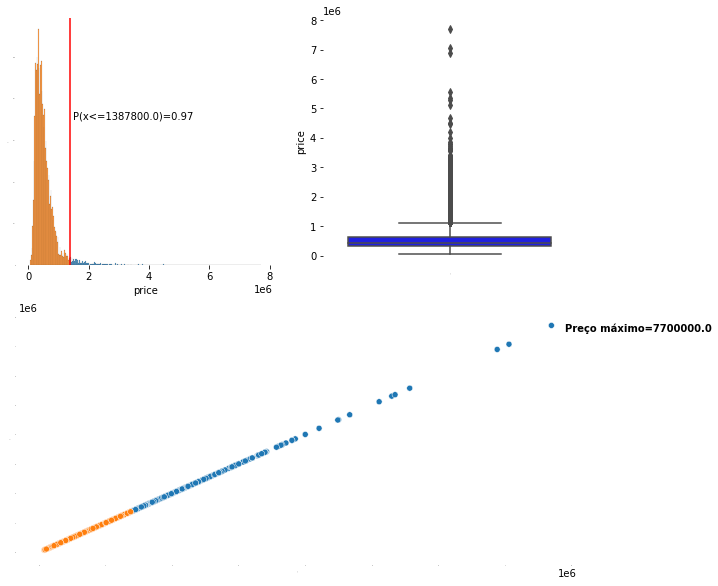

In [ ]:
#fazendo uma copia com apenas a coluna que interessa
df_aux=df['price'].copy()
df_aux=pd.DataFrame(df_aux)

#fator de probabilidade
probi=0.97

#funções auxiliares
aux, acu, maxi=acumulativo(df_aux, probi)
df_aux.insert(1,'bool',prob(df_aux, aux))


fig=plt.figure(figsize=(10,10))


#histograma
ax=fig.add_subplot(2,2,1)
sns.histplot(data=df_aux[["price","bool"]],x="price",hue="bool",multiple="stack", legend=False)
sns.despine(bottom=True, left=True)
plt.ylabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.axvline(x=maxi, ymin=0, ymax=700, color='red')
plt.text(maxi+100000, 700, f"""P(x<={maxi})={probi}""")


#boxplot
ax=fig.add_subplot(2,2,2)
sns.boxplot(y="price",data=df,color='blue')
sns.despine(bottom=True, left=True)
plt.xlabel([], fontsize=0)
plt.tick_params(axis='x', labelsize=0, length=0)


#dipersão
ax=fig.add_subplot(2,1,2)
sns.scatterplot(data=df_aux, x='price', y='price', hue='bool', legend=False)
sns.despine(bottom=True, left=True)
plt.ylabel('price')
plt.tick_params(axis='x', labelsize=0, length=0)
maximo=df['price'].max()
plt.text(maximo+200000, maximo-200000, f"Preço máximo={maximo}", weight="bold")
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

plt.show()

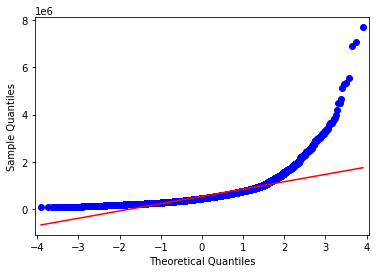

In [ ]:
smi.qqplot(df["price"], line = "r")
plt.show()

In [ ]:
stat_test, p_valor =stats.normaltest(df["price"])
alpha=0.05
if p_valor < alpha:  # hipotese nula: x vem de uma distribuição normal
    print("A hipotese nula pode ser rejeitada")
else:
    print("A hipotese nula não pode ser rejeitada")

A hipotese nula pode ser rejeitada


Como visto pelos dois gráficos acima e pelo teste de hipotese, os dados de price não seguem uma distribuição normal. Portanto não pode aplicar certos métodos para tratamento de dados, e ja podemos concluir que não poderemos usar regressão linear.

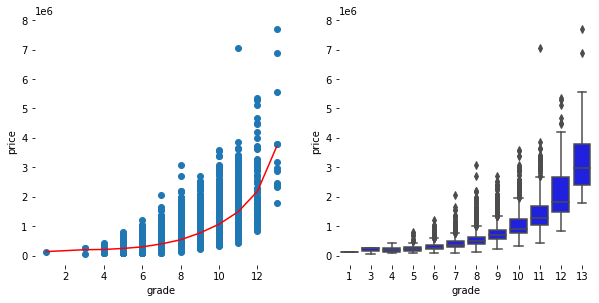

In [ ]:
grop=df[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
plt.scatter(df.grade,df.price)
plt.ylabel('price')
plt.xlabel('grade')

#função exponencial
exp=lambda x, p1, p2: p1*np.exp(p2*x)

plt.plot(grop.index,grop.price, color='red')
popt, pcov=curve_fit(exp, df.grade, df.price)
order=np.array(pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True)).reshape(-1)
y_fitted=exp(order, *popt)
#plt.plot(order,y_fitted, color='orange')


ax=fig.add_subplot(2,2,2)
sns.boxplot(x="grade",y="price",data=df,color='blue')



sns.despine(bottom=True, left=True)


uma regressão exponencial seria um modelo que se aplicaria melhor aos dados

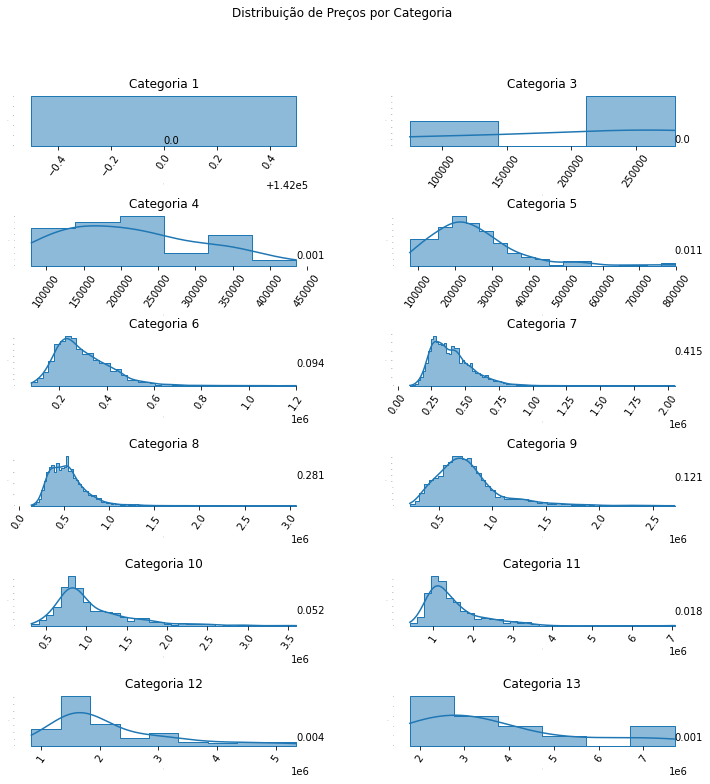

In [ ]:
fig=plt.figure(figsize=(12,12))

plt.subplots_adjust(wspace=0.3, hspace=1.3)

#pega a frequencia
cont=df['grade'].value_counts(normalize=True)


#pegar o preço mais alto de cada grade
grop=df[['grade','price']].groupby('grade').max()

#pegar a frequencia de cada preço por grade
grop2=df[['grade','price']].groupby(['grade', 'price']).size()

#colocando em ordem o vetor de valores unicos de grade
value=pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True).values
value=np.array(value).reshape(-1)

j=0
for i in value:
    j += 1
    ax = fig.add_subplot(6,2,j)
    sns.histplot(df[df.grade==i].price, kde=True, element='step')
    sns.despine(bottom=True, left=True)
    ax.set_title(f"Categoria {i}")

    for tick in ax.get_xticklabels():
            tick.set_rotation(55)
            
    plt.tick_params(axis='y', labelsize=0, length=0)
    plt.ylabel([], fontsize=0)
    plt.xlabel([], fontsize=0)
    probabi = cont[i]
    plt.text(grop.loc[i], (grop2.loc[i].sum())/25, f"""{round(probabi, 3)}""")
    fig.suptitle('Distribuição de Preços por Categoria')

    
plt.show()

#teste
#x=df[['grade','price']].groupby(['grade', 'price']).size()
#filtro=df.isin({'price':[250000], 'grade':[7]})
#print(df[(filtro.price) & (filtro.grade)].shape)
    

Conseguimos perceber melhor que os dados vem de distribuições diferentes dependendo da categoria, porem da mesma classe de distribuição com parametros diferentes

# Tratamento dos outliers

O método para identificar os outliers foi o do boxplot, pois não depende da distribuição da variavel. e os outliers estão sendo tratados por categoria

In [ ]:
order = np.array(pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True)).reshape(-1)

auxiliar = df.copy()



for gd in order:
    
    ax = df.loc[df['grade']==gd].copy()
    
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp)]=np.nan
    
    
    imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')
    imputer.fit(ax)

    #print(f'grade{gd} = {imputer.transform(ax)[:,0]}')


    auxiliar.loc[df['grade']==gd] = imputer.transform(ax)
    

ax2 = df.copy()
ax2['price'] = auxiliar['price']

print('Quantidade de outliers antes e depois')
    
total1=0
total2=0
for gd in order:
    ax0=df.loc[df['grade']==gd].copy()
    ax=ax2.loc[ax2['grade']==gd].copy()
    
    
    q33 = df['price'].quantile(0.75)
    q11 = df['price'].quantile(0.25)
    
    iqr1 = q33-q11
    lif1 = q11-(iqr1*1.5)
    lsp1 = q33+(iqr1*1.5)
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp)]=np.nan
    val1=ax['price'].isnull().sum()
    
    ax0.loc[(df['price']<lif1) | (df['price']>lsp1)]=np.nan
    val0=ax0['price'].isnull().sum()
    
    total1+=val0
    total2+=val1
    
    
    print(f"categoria {int(gd)} => {val0} | {val1}")
    
    
print(f'Total =======> {total1} | {total2} ')
    
    

Quantidade de outliers antes e depois
categoria 1 => 0 | 0
categoria 3 => 0 | 0
categoria 4 => 0 | 0
categoria 5 => 0 | 2
categoria 6 => 1 | 18
categoria 7 => 12 | 53
categoria 8 => 120 | 55
categoria 9 => 289 | 69
categoria 10 => 366 | 40
categoria 11 => 260 | 18
categoria 12 => 85 | 5
categoria 13 => 13 | 1
Total =======> 1146 | 261 


 Conseguimos tratar aproximadamente 77% dos outliers, de modo que não são mais outliers no novo conjunto de dados

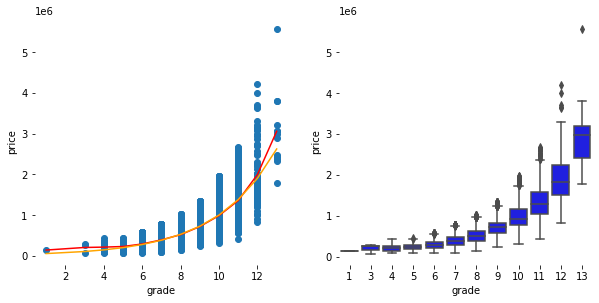

In [ ]:
grop=ax2[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
plt.scatter(ax2.grade,ax2.price)
plt.ylabel('price')
plt.xlabel('grade')

#função exponencial
exp=lambda x, p1, p2: p1*np.exp(p2*x)

plt.plot(grop.index,grop.price, color='red')
popt, pcov=curve_fit(exp, ax2.grade, ax2.price)
order=np.array(pd.DataFrame(ax2['grade'].unique()).sort_values(by=0, ascending=True)).reshape(-1)
y_fitted=exp(order, *popt)
plt.plot(order,y_fitted, color='orange')


ax=fig.add_subplot(2,2,2)
sns.boxplot(x="grade",y="price",data=ax2,color='blue')



sns.despine(bottom=True, left=True)

<bound method GLMResults.summary of <statsmodels.genmod.generalized_linear_model.GLMResults object at 0x7f57d281d990>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


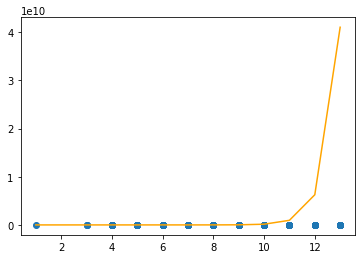

In [ ]:
gamma_model = smi.GLM(ax2['price'], ax2['grade'], family=smi.families.Gamma(link=smi.families.links.log))

gamma_results = gamma_model.fit()

print(gamma_results.summary)

order=pd.DataFrame(ax2['grade'].unique()).sort_values(by=0, ascending=True)
pred=gamma_results.predict(exog=order)

plt.scatter(ax2.grade,ax2.price)
plt.plot(np.array(order),pred, color='orange')

#Redução da Dimensão dos Dados\ PCA

In [ ]:
x=ax2.drop(columns=['grade']).values
y=ax2.grade.values
#normalizando os dados
x = pd.DataFrame(StandardScaler().fit_transform(x))
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.976272,-0.398880,-1.020232,-0.979886,-0.228352,-0.808454,-0.087183,-0.305798,-0.734721,-0.658752,-0.943353,-0.260752
1,0.083008,-0.398880,0.340497,0.533508,-0.189920,1.003503,-0.087183,-0.305798,0.460775,0.245002,-0.432704,-0.187912
2,-1.116682,-1.474106,-1.020232,-1.426283,-0.123340,-0.808454,-0.087183,-0.305798,-1.229826,-0.658752,1.070063,-0.172421
3,0.304180,0.676345,1.701227,-0.130643,-0.244043,-0.808454,-0.087183,-0.305798,-0.891706,1.397288,-0.914173,-0.284555
4,-0.010822,-0.398880,0.340497,-0.435500,-0.169690,-0.808454,-0.087183,-0.305798,-0.130935,-0.658752,-0.272214,-0.192892


In [ ]:
#pca = PCA(n_components=2)
pca = PCA(0.95)
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca['grade']=df.grade
x_pca.head()

,0,1,2,3,4,5,6,7,8,grade
0,-2.342673,0.074590,-0.006231,-0.041654,0.166962,0.463666,0.223804,0.112167,-0.134662,7
1,0.464042,-0.521004,-0.546185,-0.202057,0.009625,-0.806712,-0.433097,-0.032923,0.277646,7
2,-2.310482,0.388876,-0.012636,-0.455719,-0.992750,0.708853,-0.110838,-1.352668,-0.163014,6
3,0.068856,-0.502792,1.150415,1.449858,0.840794,-1.234182,-0.536068,0.571162,-1.076250,7
4,-0.724462,-0.096441,-0.182213,-0.025444,-0.189874,0.290981,-0.229724,0.285515,-0.979168,8


Aplicando pca de modo que consiga explicar 95% da variação obtivemos uma matriz menor com 9 atributos, ou seja, 3 colunas foram excluidas

# SVM

Conjunto sem aplicar PCA

In [ ]:
#definindo conjunto de treinamento
x=ax2.loc[:, 'price':'sqft_lot15'].drop(columns=['grade'])
y=ax2['grade']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=13)
#classificador
clasf=svm.SVC(kernel='rbf')
clasf.fit(x_train, y_train)
print("accuracy=", metrics.accuracy_score(y_test, clasf.predict(x_test)))

accuracy= 0.4951411383618695


Conjunto aplicado PCA

In [ ]:
#definindo conjunto de treinamento
x=x_pca.loc[:, 0:8]
y=x_pca['grade']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=13)
#classificador
clasf=svm.SVC(kernel='rbf')
clasf.fit(x_train, y_train)
print("accuracy=", metrics.accuracy_score(y_test, clasf.predict(x_test)))
#print(metrics.classification_report(y_test, clasf.predict(x_test)))

accuracy= 0.647539719265772
